# Advanced interfaces

## Interfaces vs. workflows

Interfaces are the building blocks that solve well-defined tasks. We solve more complex tasks by combining interfaces with workflows:

| Interfaces                                                                                                                                                                                                                                                                                    | Workflows                                                                                                                                                                                                                                                                                                                                             |
|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| <ul> <li>Wrap *unitary* tasks</li> <li>Keep track of the inputs and outputs, and check their expected types</li> <li>Do not cache results (unless you use [interface caching](http://nipype.readthedocs.io/en/latest/users/caching_tutorial.html))</li> <li>Run by a nipype plugin</li> </ul> | <ul> <li>Wrap *meta*-tasks:  <ul> <li>implemented with nipype interfaces wrapped inside ``Node`` objects</li> <li>subworkflows can also be added to a workflow without any wrapping</li> </ul>  <li>Do not have inputs/outputs, but expose them from the interfaces wrapped inside</li> <li>Cache results</li>  <li>Run by a nipype plugin</li> </ul> |

For this notebook, we'll work on the following T1-weighted dataset located in ``/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz``:

Populating the interactive namespace from numpy and matplotlib


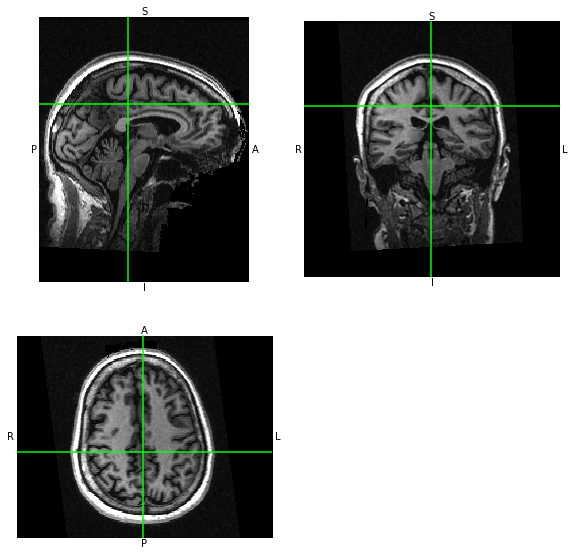

In [1]:
%pylab inline
import warnings
warnings.filterwarnings('ignore')

def plot_nii(in_file):
    import nibabel as nb
    nii =nb.load(in_file)
    nii.orthoview()
    
plot_nii('/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz')

## Example of interface: FSL's BET

Nipype offers a series of Python interfaces to various external packages (e.g. FSL, SPM or FreeSurfer) even if they themselves are written in programming languages other than python. Such interfaces know what sort of options their corresponding tool has and how to execute it.

To illustrate why interfaces are so useful, let's have a look at the brain extraction algorithm [BET](http://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET) from FSL. Once in its original framework and once in the Nipype framework.

The tool can be run directly in a bash shell using the following command line:

In [2]:
%%bash
bet /home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz /home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w_bet.nii.gz

... which yields the following:

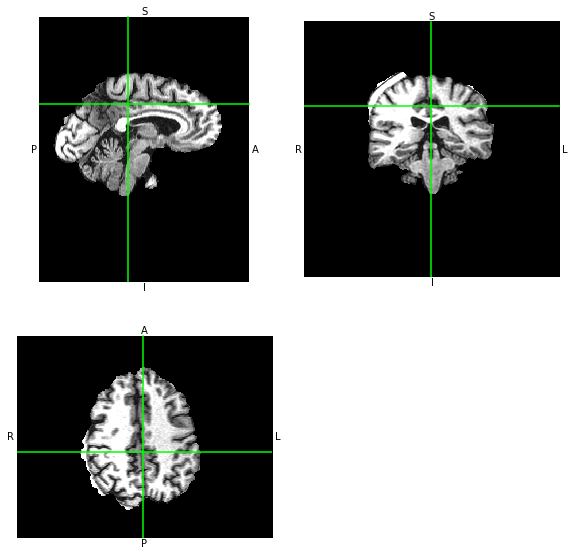

In [3]:
plot_nii('/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w_bet.nii.gz')

Using nipype, the equivalent is a bit more verbose:
  - The first line imports the interface
  - Then, the interface is instantiated. We provide here the input file.
  - Finally, we run the interface
  - The output file name can be automatically handled by nipype, and we will use that feature here

In [4]:
from nipype.interfaces.fsl import BET
skullstrip = BET(in_file = "/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz")
res = skullstrip.run()

And we can check how the result is exactly the same as before. Please note that, since we are using a Python environment, we use the result of the execution to point our ``plot_anat`` function to the output image of running BET:

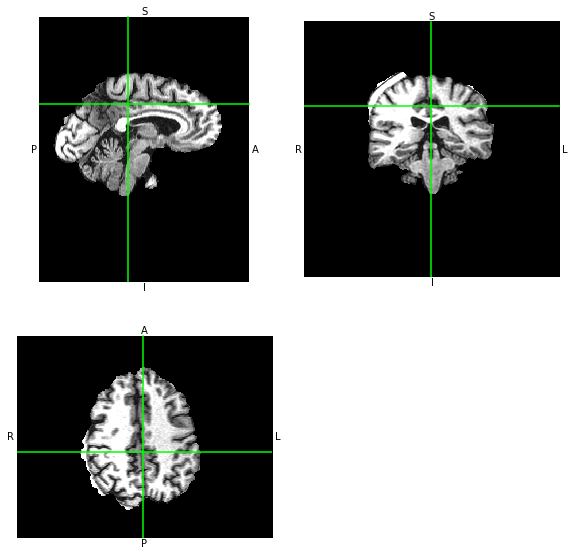

In [5]:
plot_nii(res.outputs.out_file)

## But wait! My tool is not (yet) supported by Nipype

Nipype is designed to ease writing interfaces for new software. Nipype interfaces are designed with three elements that are intuitive:
  - A specification of inputs (or the ``InputSpec``)
  - A specification of outputs (or the ``OutputSpec``)
  - An interface *core* which implements the ``run()`` method we've seen before for BET, and which puts together inputs and outputs.
  
### The ``CommandLine`` interface

The easiest / quickest way to run any command line is the ``CommandLine`` interface, which has a very simple specification of inputs ready to use:

In [6]:
from nipype.interfaces.base import CommandLine
CommandLine.help()

Wraps command **None**

Implements functionality to interact with command line programs
class must be instantiated with a command argument

Parameters
----------

command : string
    define base immutable `command` you wish to run

args : string, optional
    optional arguments passed to base `command`


Examples
--------
>>> import pprint
>>> from nipype.interfaces.base import CommandLine
>>> cli = CommandLine(command='ls', environ={'DISPLAY': ':1'})
>>> cli.inputs.args = '-al'
>>> cli.cmdline # doctest: +ALLOW_UNICODE
'ls -al'

>>> pprint.pprint(cli.inputs.trait_get())  # doctest: +NORMALIZE_WHITESPACE +ALLOW_UNICODE
{'args': '-al',
 'environ': {'DISPLAY': ':1'},
 'ignore_exception': False,
 'terminal_output': 'stream'}

>>> cli.inputs.get_hashval()[0][0] # doctest: +ALLOW_UNICODE
('args', '-al')
>>> cli.inputs.get_hashval()[1] # doctest: +ALLOW_UNICODE
'11c37f97649cd61627f4afe5136af8c0'

Inputs::

	[Mandatory]

	[Optional]
	args: (a unicode string)
		Additional parameters to the co

As a quick example, let's wrap the bash's ``ls`` with Nipype:

In [7]:
nipype_ls = CommandLine('ls', args='-lh', terminal_output='file')

Now, we have a Python object ``nipype_ls`` that is a runnable nipype interface. After execution, Nipype interface return a result object. We can retrieve the output of our ``ls`` invocation from the ``result.runtime`` property:

In [8]:
result = nipype_ls.run()
print(result.runtime.stdout)

total 34M
-rw-r--r-- 1 jovyan staff 1.2M Mar 28 11:30 advanced_interfaces.ipynb
-rw-r--r-- 1 jovyan staff 714K Mar 27 21:02 advanced_workflows.ipynb
-rw-r--r-- 1 jovyan staff 797K Mar 27 04:07 basic_workflow.ipynb
drwxr-xr-x 1 jovyan staff  102 Mar 26 22:21 data
-rw-r--r-- 1 jovyan staff  295 Mar 26 21:08 Dockerfile
-rw-r--r-- 1 jovyan staff 848K Mar 26 23:05 example_metaflow.ipynb
drwxr-xr-x 1 jovyan staff  136 Mar 26 21:08 files
-rw-r--r-- 1 jovyan staff  289 Mar 26 22:53 run_docker.sh
-rw-r--r-- 1 jovyan staff    0 Mar 28 11:36 stderr.nipype
-rw-r--r-- 1 jovyan staff    0 Mar 28 11:36 stdout.nipype
-rw-r--r-- 1 jovyan staff 1.7M Mar 28 11:36 sub-01_T1w_brain.nii.gz
-rw-r--r-- 1 jovyan staff  29M Mar 28 11:28 translated.nii.gz
drwxr-xr-x 1 jovyan staff  102 Mar 27 04:04 working_dir


## My first implementation of a Nipype Interface to an external tool

Let's create a Nipype Interface for a very simple tool called ``antsTransformInfo`` from the [ANTs](http://stnava.github.io/ANTs/) package. This tool is so simple it does not even have an usage description for bash. Using it with a file, gives us the following result: 

In [9]:
!antsTransformInfo files/transform.tfm

Transform file: files/transform.tfm
AffineTransform (0x2890750)
  RTTI typeinfo:   itk::AffineTransform<double, 3u>
  Reference Count: 3
  Modified Time: 660
  Debug: Off
  Object Name: 
  Observers: 
    none
  Matrix: 
    1.0201 -0.00984231 0.00283729 
    -0.245557 0.916396 0.324585 
    -0.0198016 -0.00296066 0.988634 
  Offset: [2.00569, -15.15, -1.26341]
  Center: [-3.37801, 17.4338, 8.46811]
  Translation: [1.79024, -13.0295, -1.34439]
  Inverse: 
    0.982713 0.0105343 -0.00627888 
    0.256084 1.09282 -0.359526 
    0.0204499 0.00348366 1.01029 
  Singular: 0



So let's plan our implementation:

  1. The command line name is ``antsTransformInfo``
  2. It only accepts one text file (containing an ITK transform file) as input, and it is a positional argument
  3. Then, it prints out the properties of the transform in the input file. For the purpose of this guide, we are only interested on extracting the translation values.
  
For the first item of this roadmap, we will just need to derive a new Python class from the ``nipype.interfaces.base.CommandLine`` base. To indicate the appropriate command line, we set the member ``_cmd``:

In [10]:
class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'

This is enough to have a nipype compatible interface for this tool:

In [11]:
TransformInfo.help()

Wraps command **antsTransformInfo**


Inputs::

	[Mandatory]

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	environ: (a dictionary with keys which are a bytes or None or a value
		 of class 'str' and with values which are a bytes or None or a value
		 of class 'str', nipype default value: {})
		Environment variables
	ignore_exception: (a boolean, nipype default value: False)
		Print an error message instead of throwing an exception in case the
		interface fails to run
	terminal_output: ('stream' or 'allatonce' or 'file' or 'none')
		Control terminal output: `stream` - displays to terminal immediately
		(default), `allatonce` - waits till command is finished to display
		output, `file` - writes output to file, `none` - output is ignored

Outputs::

	None




#### Specifying the inputs

However, the ``args`` argument is too generic and does not deviate much from just running it in bash, or directly using ``subprocess.Popen``. Let's define the intputs specification for the interface, extending the ``nipype.interfaces.base.CommandLineInputSpec`` class.

The inputs are implemented using the Enthought traits package. For now, we'll use the ``File`` trait extension of nipype:

In [12]:
from nipype.interfaces.base import CommandLineInputSpec, File

class TransformInfoInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s', position=0, desc='the input transform file')

Some settings are done for this ``File`` object: the ``exists=True`` bit indicates Nipype that the file must exist when it is set. The ``mandatory=True`` checks that this input was set before running because the program would crash otherwise. The ``argstr='%s'`` indicates how this input parameter should be formatted. Finally, ``position=0`` indicates that this is the first positional argument.

We can now decorate our ``TransformInfo`` core class with its input, by setting the ``input_spec`` member:

In [13]:
class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec

Our interface now has one mandatory input, and inherits some optional inputs from the ``CommandLineInputSpec``:

In [14]:
TransformInfo.help()

Wraps command **antsTransformInfo**


Inputs::

	[Mandatory]
	in_file: (an existing file name)
		the input transform file
		flag: %s, position: 0

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	environ: (a dictionary with keys which are a bytes or None or a value
		 of class 'str' and with values which are a bytes or None or a value
		 of class 'str', nipype default value: {})
		Environment variables
	ignore_exception: (a boolean, nipype default value: False)
		Print an error message instead of throwing an exception in case the
		interface fails to run
	terminal_output: ('stream' or 'allatonce' or 'file' or 'none')
		Control terminal output: `stream` - displays to terminal immediately
		(default), `allatonce` - waits till command is finished to display
		output, `file` - writes output to file, `none` - output is ignored

Outputs::

	None




One interesting feature of the Nipype interface is that the underlying command line can be checked using the object property ``cmdline``. The command line can only be built when the mandatory inputs are set, so let's instantiate our new Interface for first time, and check the underlying command line:

In [15]:
my_info_interface = TransformInfo(in_file='files/transform.tfm')
print(my_info_interface.cmdline)

antsTransformInfo files/transform.tfm


Nipype will make sure that the parameters fullfil their prescribed attributes. For instance ``in_file`` is mandatory. An error is issued if we build the command line or try to run this interface without it:

In [16]:
TransformInfo().cmdline

ValueError: TransformInfo requires a value for input 'in_file'. For a list of required inputs, see TransformInfo.help()

It will also complain if we try to set a non-existent file:

In [17]:
my_info_interface.inputs.in_file = 'idontexist.tfm'

TraitError: The 'in_file' trait of a TransformInfoInputSpec instance must be an existing file name, but a value of 'idontexist.tfm' <class 'str'> was specified.

#### Specifying the outputs
The outputs are defined in a similar way. Let's define a custom output for our interface which is a list of three float element. The output traits are derived from a simpler base class called ``TraitedSpec``. We also import the two data representations we need ``List`` and ``Float``:

In [18]:
from nipype.interfaces.base import TraitedSpec, traits

class TransformInfoOutputSpec(TraitedSpec):
    translation = traits.List(traits.Float, desc='the translation component of the input transform')
    
class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec
    output_spec = TransformInfoOutputSpec

And now, the our new output is in place:

In [19]:
TransformInfo.help()

Wraps command **antsTransformInfo**


Inputs::

	[Mandatory]
	in_file: (an existing file name)
		the input transform file
		flag: %s, position: 0

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	environ: (a dictionary with keys which are a bytes or None or a value
		 of class 'str' and with values which are a bytes or None or a value
		 of class 'str', nipype default value: {})
		Environment variables
	ignore_exception: (a boolean, nipype default value: False)
		Print an error message instead of throwing an exception in case the
		interface fails to run
	terminal_output: ('stream' or 'allatonce' or 'file' or 'none')
		Control terminal output: `stream` - displays to terminal immediately
		(default), `allatonce` - waits till command is finished to display
		output, `file` - writes output to file, `none` - output is ignored

Outputs::

	translation: (a list of items which are a float)
		the translation component of the input transform




#### We are almost there: final needs
If we run the interface, we'll be able to see that this tool only writes some text to the standard output, but we just want to extract the ``Translation`` field and generate a Python object from it.

In [20]:
my_info_interface = TransformInfo(in_file='files/transform.tfm', terminal_output='file')
result = my_info_interface.run()

print(result.runtime.stdout)

Transform file: files/transform.tfm
AffineTransform (0x276d750)
RTTI typeinfo:   itk::AffineTransform<double, 3u>
Reference Count: 3
Modified Time: 660
Debug: Off
Object Name:
Observers:
none
Matrix:
1.0201 -0.00984231 0.00283729
-0.245557 0.916396 0.324585
-0.0198016 -0.00296066 0.988634
Offset: [2.00569, -15.15, -1.26341]
Center: [-3.37801, 17.4338, 8.46811]
Translation: [1.79024, -13.0295, -1.34439]
Inverse:
0.982713 0.0105343 -0.00627888
0.256084 1.09282 -0.359526
0.0204499 0.00348366 1.01029
Singular: 0



We need to complete the functionallity of the ``run()`` member of our interface to parse the standard output. This is done extending its ``_run_interface()`` member.

When we define outputs, generally they need to be explicitly wired in the ``_list_outputs()`` member of the core class. Let's see how we can *complete* those:

In [21]:
class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec
    output_spec = TransformInfoOutputSpec
            
    def _run_interface(self, runtime):
        import re
        
        # Run the command line as a natural CommandLine interface
        runtime = super(TransformInfo, self)._run_interface(runtime)

        # Search transform in the standard output
        expr_tra = re.compile('Translation:\s+\[(?P<translation>[0-9\.-]+,\s[0-9\.-]+,\s[0-9\.-]+)\]')
        trans = [float(v) for v in expr_tra.search(runtime.stdout).group('translation').split(', ')]
        
        # Save it for later use in _list_outputs
        setattr(self, '_result', trans)
        
        # Good to go
        return runtime
    
    def _list_outputs(self):
        # Get the attribute saved during _run_interface
        return {'translation': getattr(self, '_result')}


Let's run this interface (we set ``terminal_output='file'`` to reduce the length of this manual):

In [22]:
my_info_interface = TransformInfo(in_file='files/transform.tfm', terminal_output='file')
result = my_info_interface.run()

Now we can retrieve our outcome of interest as an output:

In [23]:
result.outputs.translation

[1.79024, -13.0295, -1.34439]

#### Putting all together

In [24]:
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, traits, File

class TransformInfoInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s', position=0, desc='the input transform file')

class TransformInfoOutputSpec(TraitedSpec):
    translation = traits.List(traits.Float, desc='the translation component of the input transform')

class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec
    output_spec = TransformInfoOutputSpec
            
    def _run_interface(self, runtime):
        import re
        
        # Run the command line as a natural CommandLine interface
        runtime = super(TransformInfo, self)._run_interface(runtime)

        # Search transform in the standard output
        expr_tra = re.compile('Translation:\s+\[(?P<translation>[0-9\.-]+,\s[0-9\.-]+,\s[0-9\.-]+)\]')
        trans = [float(v) for v in expr_tra.search(runtime.stdout).group('translation').split(', ')]
        
        # Save it for later use in _list_outputs
        setattr(self, '_result', trans)
        
        # Good to go
        return runtime
    
    def _list_outputs(self):
        # Get the attribute saved during _run_interface
        return {'translation': getattr(self, '_result')}


#### Wrapping up
For more standard neuroimaging software, generally we will have input and output images. If that is the case, then there is no need to extend the ``run()`` method. Let's look at a quick, partial, implementation of FSL's BET:

In [25]:
from nipype.interfaces.base import CommandLineInputSpec, File, TraitedSpec

class CustomBETInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s', position=0, desc='the input image')
    out_file = File(mandatory=True, argstr='%s', position=1, desc='the output image') # Do not set exists=True !!
    
class CustomBETOutputSpec(TraitedSpec):
    out_file = File(desc='the output image')
    
class CustomBET(CommandLine):
    _cmd = 'bet'
    input_spec = CustomBETInputSpec
    output_spec = CustomBETOutputSpec
    
    def _list_outputs(self):
        # Get the attribute saved during _run_interface
        return {'out_file': self.inputs.out_file}

In [26]:
my_custom_bet = CustomBET()
my_custom_bet.inputs.in_file = '/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz'
my_custom_bet.inputs.out_file = 'sub-01_T1w_brain.nii.gz'
result = my_custom_bet.run()

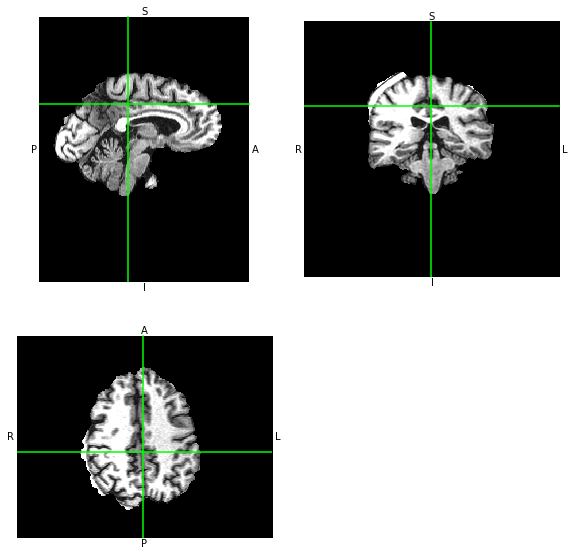

In [27]:
plot_nii(result.outputs.out_file)

## Great, but my tool is already Python - can I wrap it natively?

Sure. Let's solve the following problem. For years, I've been working on a Python function that would take an input image and a list of three translations (x, y, z) in mm, and write a resampled image after the translation has been applied:

In [28]:
def translate_image(img, translation, out_file):
    import nibabel as nb
    import numpy as np
    from scipy.ndimage.interpolation import affine_transform
    
    nii = nb.load(img)
    data = nii.get_data()
    
    matrix = np.eye(3)
    trans = (np.array(translation) / nii.header.get_zooms()[:3]) * np.array([1.0, -1.0, -1.0])
    
    newdata = affine_transform(data, matrix=matrix, offset=trans)
    
    nb.Nifti1Image(newdata, nii.affine, nii.header).to_filename(out_file)
    
    print('Translated file now is here: %s' % out_file)
    

Let's see how this function operates:

Translated file now is here: translated.nii.gz


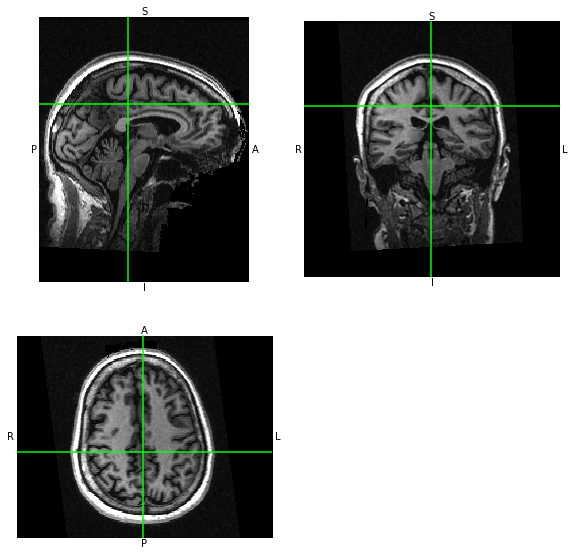

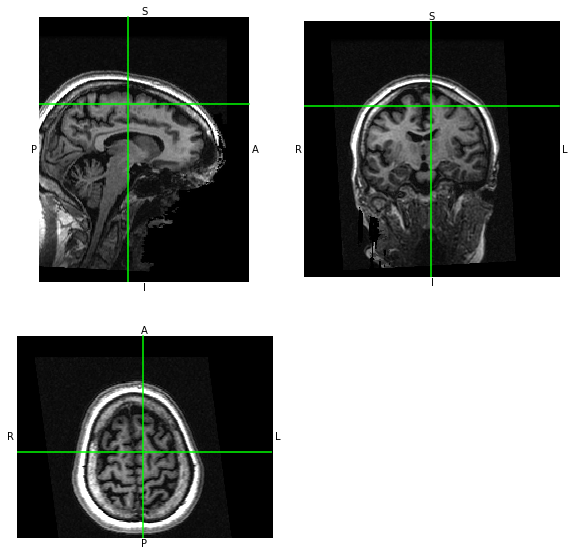

In [29]:
plot_nii('/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz')
translate_image('/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz', [5.0, -20.0, -18.0], 'translated.nii.gz')
plot_nii('translated.nii.gz')

## The fast track: using the ``Function`` interface

If, like in this case, we have a well-defined function we want to run with Nipype, it is fairly easy to solve with the ``Function`` interface:

In [30]:
from nipype.interfaces.utility import Function

my_python_interface = Function(
    input_names=['img', 'translation', 'out_file'],
    output_names=['out_file'],
    function=translate_image
)

The arguments of ``translate_image`` need to be listed in the same order and with the same names as in the signature of the function. For the outputs, it is only necessary to set the same order. Finally, the ``Function`` interface takes a ``function`` input that is pointed to your python code.

The inputs and outputs do not pass any kind of conformity checking: the function node will take any kind of data type for their inputs and outputs.

There are some other limitations for the ``Function`` interface when used inside workflows. Additionally, the function must be totally self-contained, since it will run with no global context. In practice, it means that **all the imported modules and variables must be defined within the context of the function**.

They are run as any other interface object of nipype:

Translated file now is here: translated_functioninterface.nii.gz


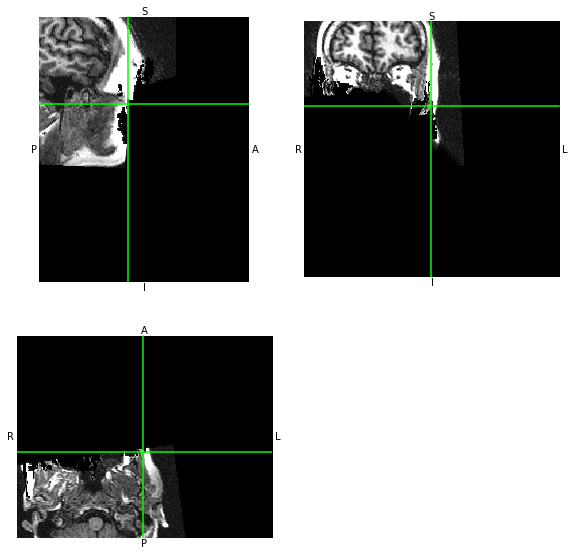

In [31]:
# Set inputs
my_python_interface.inputs.img = '/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz'
my_python_interface.inputs.translation = [50.0, -70.0, 80.0]
my_python_interface.inputs.out_file = 'translated_functioninterface.nii.gz'

# Run the interface
result = my_python_interface.run()

# Plot the result
plot_nii('translated_functioninterface.nii.gz')

## The long support track: pure python interfaces

Now, we face the problem of interfacing something different from a command line. Therefore, the ``CommandLine`` base class will not useful anymore here.

The specification of the inputs and outputs, though, will work the same way. Let's start from that point. Our Python function takes in three inputs: the input image, the translation and an output image.

The specification of inputs and outputs must be familiar at this point. Please note that now, out input specification is derived from ``BaseInterfaceInputSpec``, which is a bit thinner than ``CommandLineInputSpec``. The output specification can be derived from ``TraitedSpec`` as before:

In [32]:
from nipype.interfaces.base import BaseInterfaceInputSpec

class TranslateImageInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True, desc='the input image')
    out_file = File(mandatory=True, desc='the output image') # Do not set exists=True !!
    translation = traits.List([100.0, 0.0, 0.0], traits.Float, usedefault=True,
                              desc='the translation component of the input transform')
    
class TranslateImageOutputSpec(TraitedSpec):
    out_file = File(desc='the output image')

Similarily to the change of base class for the input specification, the core of our new interface will derive from ``BaseInterface`` instead of ``CommandLineInterface``:

In [33]:
from nipype.interfaces.base import BaseInterface

class TranslateImage(BaseInterface):
    input_spec = TranslateImageInputSpec
    output_spec = TranslateImageOutputSpec
    

At this point, we have defined a pure python interface but it is unable to do anything because does not implement a ``_run_interface()`` method. That's a characteristic of the ``BaseInterface`` (it is virtual):

In [34]:
TranslateImage.help()


Inputs::

	[Mandatory]
	in_file: (an existing file name)
		the input image
	out_file: (a file name)
		the output image

	[Optional]
	ignore_exception: (a boolean, nipype default value: False)
		Print an error message instead of throwing an exception in case the
		interface fails to run
	translation: (a list of items which are a float, nipype default
		 value: [100.0, 0.0, 0.0])
		the translation component of the input transform

Outputs::

	out_file: (a file name)
		the output image




In [35]:
will_fail_at_run = TranslateImage(in_file='/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz', out_file='translated.nii.gz')
result = will_fail_at_run.run()

NotImplementedError: 
Interface TranslateImage failed to run.

As we would imagine, this needs to be really similar to what we did before with the ``TransformInfo`` interface:

In [36]:
class TranslateImage(BaseInterface):
    input_spec = TranslateImageInputSpec
    output_spec = TranslateImageOutputSpec
    
    def _run_interface(self, runtime):
        # Call our python code here:
        translate_image(
            self.inputs.in_file,
            self.inputs.translation,
            self.inputs.out_file
        )
        
        # And we are done
        return runtime

If we run that, then we would have some success:

In [37]:
half_works = TranslateImage(in_file='/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz', out_file='translated_nipype.nii.gz')
result = half_works.run()

Translated file now is here: translated_nipype.nii.gz


NotImplementedError: 
Interface TranslateImage failed to run.

.. but we would also be making a mistake, leaving aside the ``_list_outputs()`` method. Our python function is called, but the interface crashes when the execution arrives to retrieving the outputs. Let's fix that:

In [38]:
from nipype.interfaces.base import BaseInterfaceInputSpec, BaseInterface

class TranslateImageInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True, desc='the input image')
    out_file = File(mandatory=True, desc='the output image') # Do not set exists=True !!
    translation = traits.List([100.0, 0.0, 0.0], traits.Float, usedefault=True,
                              desc='the translation component of the input transform')
    
class TranslateImageOutputSpec(TraitedSpec):
    out_file = File(desc='the output image')
    
class TranslateImage(BaseInterface):
    input_spec = TranslateImageInputSpec
    output_spec = TranslateImageOutputSpec
    
    def _run_interface(self, runtime):
        # Call our python code here:
        translate_image(
            self.inputs.in_file,
            self.inputs.translation,
            self.inputs.out_file
        )
        # And we are done
        return runtime

    def _list_outputs(self):
        return {'out_file': self.inputs.out_file}


In [39]:
this_works = TranslateImage(in_file='/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz', out_file='translated_nipype.nii.gz')
result = this_works.run()

Translated file now is here: translated_nipype.nii.gz


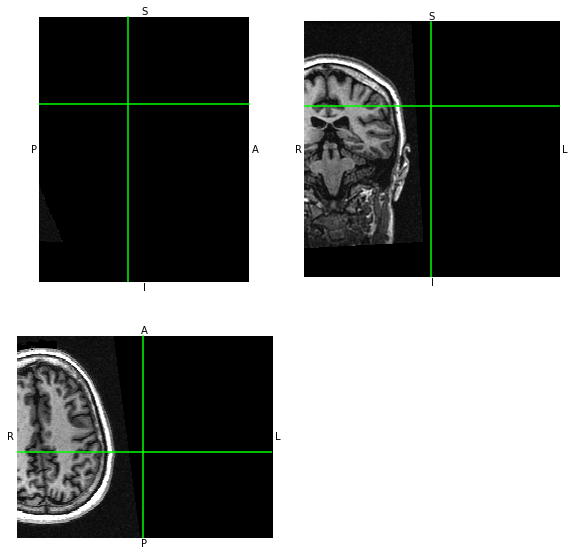

In [40]:
plot_nii(result.outputs.out_file)

## Using MATLAB

Let's run some matlab code to count the number of voxels with intensity larger than zero. That would give us an estimation of the brain volume (in voxels) of a skull-stripped image.

In MATLAB, our code looks like:

  ```
  load input_image.mat;
  total = sum(data(:) > 0)
  ```
  
The following example, uses ``scipy.io.savemat`` to convert the input image to matlab format. Then the file is loaded in the MATLAB script and the volume estimated.

In [41]:
from nipype.interfaces.matlab import MatlabCommand, MatlabInputSpec
from nipype.interfaces.base import traits, TraitedSpec, BaseInterface, BaseInterfaceInputSpec, File
import os
import re
import nibabel as nb
from scipy.io import savemat

class BrainVolumeMATLABInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True)
    script_file = File(exists=True, mandatory=True)
    
class BrainVolumeMATLABOutputSpec(TraitedSpec):
    volume = traits.Int(desc='brain volume')

class BrainVolumeMATLAB(BaseInterface):
    input_spec = BrainVolumeMATLABInputSpec
    output_spec = BrainVolumeMATLABOutputSpec
    
    def _run_interface(self, runtime): 
        # Save the image in matlab format as tmp_image.mat
        tmp_image = 'tmp_image'
        data = nb.load(self.inputs.in_file).get_data()
        savemat(tmp_image, {b'data': data}, do_compression=False)
        
        # Load script
        with open(self.inputs.script_file) as script_file:
            script_content = script_file.read()
        
        # Replace the input_image.mat file for the actual input of this interface
        with open('newscript.m', 'w') as script_file:
            script_file.write(script_content.replace('input_image.mat', 'tmp_image.mat'))

        # Run a matlab command
        mlab = CommandLine('octave', args='newscript.m', terminal_output='file')
        result = mlab.run()
        
        expr_tra = re.compile('total\ =\s+(?P<total>[0-9]+)')
        volume = int(expr_tra.search(result.runtime.stdout).groupdict()['total'])
        setattr(self, '_result', volume)
        return result.runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs['volume'] = getattr(self, '_result')
        return outputs

In [42]:
matlab = BrainVolumeMATLAB(in_file='/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz', script_file='files/brainvolume.m')
result = matlab.run()
print(result.outputs)


volume = 5308353



## Exercise:

Modify the BrainVolumeMATLAB interface so that it has one more **output** called ``out_file``, that points to a text file where we write the volume in voxels. The name of the ``out_file`` can be hard coded to ``volume.txt``.

In [ ]:
from nipype.interfaces.matlab import MatlabCommand, MatlabInputSpec
from nipype.interfaces.base import traits, TraitedSpec, BaseInterface, BaseInterfaceInputSpec, File
import os
import re
import nibabel as nb
from scipy.io import savemat

class BrainVolumeMATLABInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True)
    script_file = File(exists=True, mandatory=True)
    
class BrainVolumeMATLABOutputSpec(TraitedSpec):
    volume = traits.Int(desc='brain volume')

class BrainVolumeMATLAB(BaseInterface):
    input_spec = BrainVolumeMATLABInputSpec
    output_spec = BrainVolumeMATLABOutputSpec
    
    def _run_interface(self, runtime): 
        # Save the image in matlab format as tmp_image.mat
        tmp_image = 'tmp_image'
        data = nb.load(self.inputs.in_file).get_data()
        savemat(tmp_image, {b'data': data}, do_compression=False)
        
        # Load script
        with open(self.inputs.script_file) as script_file:
            script_content = script_file.read()
        
        # Replace the input_image.mat file for the actual input of this interface
        with open('newscript.m', 'w') as script_file:
            script_file.write(script_content.replace('input_image.mat', 'tmp_image.mat'))

        # Run a matlab command
        mlab = CommandLine('octave', args='newscript.m', terminal_output='file')
        result = mlab.run()
        
        expr_tra = re.compile('total\ =\s+(?P<total>[0-9]+)')
        volume = int(expr_tra.search(result.runtime.stdout).groupdict()['total'])
        setattr(self, '_result', volume)
        return result.runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs['volume'] = getattr(self, '_result')
        return outputs

In [ ]:
matlab = BrainVolumeMATLAB(in_file='/home/jovyan/work/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz', script_file='files/brainvolume.m')
result = matlab.run()
print(result.outputs.out_file)